In [18]:
import sys
sys.path.append('../scripts')

import pandas as pd
import os
import numpy as np

from matplotlib import pyplot as plt
import matplotlib.ticker as ticker

from model_training import (set_reproducibility, train_atomsets_classification_kfold)
from data_analysis import (get_kfold_run_average_std, get_controls, get_best_epoch_across_kfolds)

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, matthews_corrcoef, accuracy_score
from sklearn.preprocessing import MinMaxScaler

import warnings

warnings.filterwarnings("ignore")

### Define paths for relevant directories

In [19]:
train_val_split_path = r"..\data\ionic_conductivity_database_11022023_train_val_test_splits3\classification\kfold"
feature_path = r"..\data\graph_based_features_11022023_wo_duplicates.pkl"
atomistic_feature_path = r"..\data\atomistic_features_11022023.pkl"
controls_path = r"..\data\controls.json"
kfold_results_path = r"..\data\kfold_results.csv"

### Load features

In [13]:
feature_df = pd.read_pickle(feature_path)
atomistic_feature_df = pd.read_pickle(atomistic_feature_path)

## Compare training performance between ordered and disordered representation

### Train AtomSets model with feature derived from ordered structure representaton

In [ ]:
feature = "ordered_structure_wo_Li_megnet_site_feature_level_1_2019_4_1_formation_energy"
subset_feature = "ordered_structure_wo_Li_megnet_site_feature_level_1_2019_4_1_formation_energy"
target = "is_superionic"
pretrained_model_path = r".\data\pretrained_atomsets_models\matbench_v_0_1_is_metal_structure_megnet_site_feature_level_1_2019_4_1_formation_energy_trained_300epochs_nl2nn64\model_weights.hdf5"
pretraining = False

for fold in os.listdir(train_val_split_path):
    train_atomsets_classification_kfold(train_val_split_path=train_val_split_path, 
                                  fold=fold, 
                                  feature_df=feature_df, 
                                  feature=feature,
                                  target=target,
                                  pretraining=pretraining,
                                  pretrained_model_path=pretrained_model_path,
                                  subset_feature=subset_feature)

### Train AtomSets model with feature derived from disordered structure representaton

In [ ]:
feature = "structure_wo_Li_megnet_site_feature_level_1_2019_4_1_formation_energy"
subset_feature = "ordered_structure_wo_Li_megnet_site_feature_level_1_2019_4_1_formation_energy"
target = "is_superionic"
pretrained_model_path = r".\data\pretrained_atomsets_models\matbench_v_0_1_is_metal_structure_megnet_site_feature_level_1_2019_4_1_formation_energy_trained_300epochs_nl2nn64\model_weights.hdf5"
pretraining = False

for fold in os.listdir(train_val_split_path):
    train_atomsets_classification(train_val_split_path=train_val_split_path, 
                                  fold=fold, 
                                  feature_df=feature_df, 
                                  feature=feature,
                                  target=target,
                                  pretraining=pretraining,
                                  pretrained_model_path=pretrained_model_path,
                                  subset_feature=subset_feature)

### Create figure comparing training results with ordered vs. ordered representation feature representations

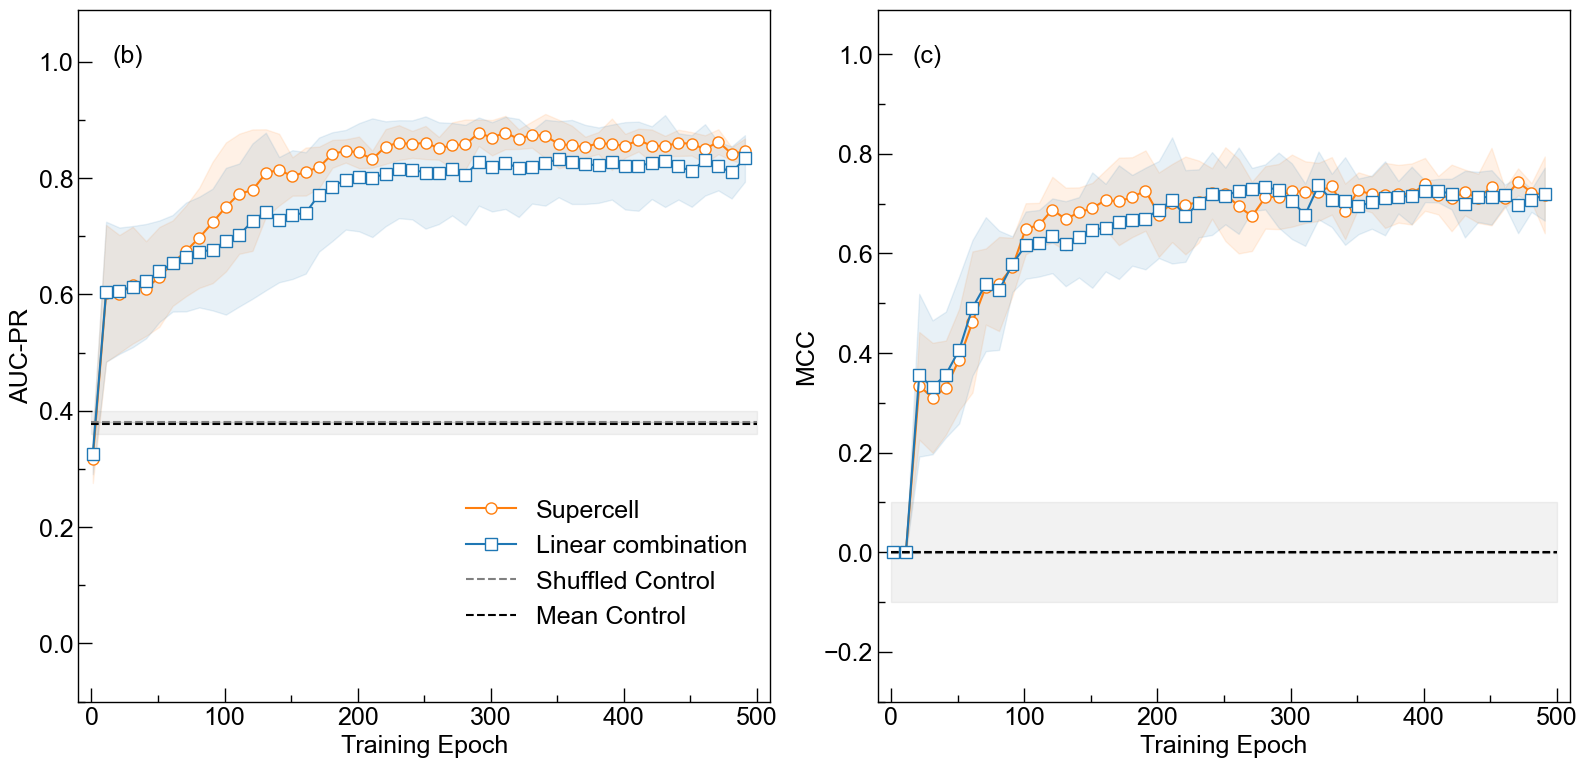

In [15]:
fig = plt.figure(figsize=(16, 8))

plt.rcParams['font.family'] = 'Arial'
plt.subplot(1, 2, 1)
plt.xlabel('Training Epoch', fontsize=18)
plt.ylabel('AUC-PR', fontsize=18)
plt.ylim([-0.1, 1.09])
plt.xlim([-10, 510])
plt.text(0.05, 0.95, '(b)', fontsize=18, verticalalignment='top', horizontalalignment='left', transform=plt.gca().transAxes)
plt.gca().set_aspect(np.diff(plt.gca().get_xlim()) / np.diff(plt.gca().get_ylim()))
# Define markers, line styles, and colors for better distinction
markers = ['o', 's', 'd', '^']  # Circle, square, diamond, triangle

colors = ["tab:orange", "tab:blue", "tab:blue"]

features = [
    "ordered_structure_wo_Li_megnet_site_feature_level_1_2019_4_1_formation_energy",
    "structure_wo_Li_megnet_site_feature_level_1_2019_4_1_formation_energy",
]

labels = [
    "Supercell",
    "Linear combination",
]

xlim = 500
metric='val_pr_auc'
for i, feature in enumerate(features):
    color = colors[i]
    average_feature_data, std_feature_data = get_kfold_run_average_std(data_dir=train_val_split_path, feature=feature)
    
    # Truncate the data based on xlim
    average_feature_data = average_feature_data[:xlim]
    std_feature_data = std_feature_data[:xlim]
    
    training_epochs = np.arange(1, len(average_feature_data) + 1)
    
    # Downsample data by selecting every nth data point
    n = 10
    training_epochs_downsampled = training_epochs[::n]
    average_feature_data_downsampled = average_feature_data[::n]
    std_feature_data_downsampled = std_feature_data[::n]

    plt.plot(training_epochs_downsampled, average_feature_data_downsampled[metric], 
             label=labels[i], 
             marker=markers[i % len(markers)], 
             markerfacecolor='w',
             markersize=8,
             color=color)
    plt.fill_between(training_epochs_downsampled, 
                     average_feature_data_downsampled[metric] - std_feature_data_downsampled[metric], 
                     average_feature_data_downsampled[metric] + std_feature_data_downsampled[metric], 
                     alpha=0.1, color=color)

# Set different lengths for major and minor ticks
plt.tick_params(axis='both', which='major', direction='in', length=10, width=1, labelsize=18, colors='k')
plt.tick_params(axis='both', which='minor', direction='in', length=5, width=1, colors='k')
plt.minorticks_on()  # Show minor ticks

# Set the interval of minor ticks to 5
plt.gca().xaxis.set_minor_locator(ticker.AutoMinorLocator(2))
plt.gca().yaxis.set_minor_locator(ticker.AutoMinorLocator(2))
plt.gca().spines['top'].set_linewidth(1)  # Adjust the width of the top outline
plt.gca().spines['bottom'].set_linewidth(1)  # Adjust the width of the bottom outline
plt.gca().spines['left'].set_linewidth(1)  # Adjust the width of the left outline
plt.gca().spines['right'].set_linewidth(1)  # Adjust the width of the right outline

mean_control_avg, mean_control_std, shuffled_control_avg, shuffled_control_std = get_controls(controls_filepath=controls_path, 
                                                                                              validation_type='kfold',
                                                                                              metric=metric, 
                                                                                              fold=None)

plt.hlines(shuffled_control_avg, xmin=0, xmax=500, color='gray', linestyle='--', linewidth=1.5, label='Shuffled Control')
plt.fill_betweenx(np.arange(-0.1, 1.05, 0.01), 0, 500, 
                  where=(np.arange(-0.1, 1.05, 0.01) >= shuffled_control_avg - shuffled_control_std) & (np.arange(-0.1, 1.05, 0.01) <= shuffled_control_avg + shuffled_control_std),
                  color='gray', alpha=0.1)

plt.hlines(mean_control_avg, xmin=0, xmax=500, color='black', linestyle='--', linewidth=1.5, label='Mean Control')
plt.fill_betweenx(np.arange(-0.1, 1.05, 0.01), 0, 500, 
                  where=(np.arange(-0.1, 1.05, 0.01) >= mean_control_avg - mean_control_std) & (np.arange(-0.1, 1.05, 0.01) <= mean_control_avg + mean_control_std),
                  color='black', alpha=0.1)



plt.legend(loc='upper right', bbox_to_anchor=(1, 0.325), fontsize=18, frameon=False)

plt.subplot(1, 2, 2)

plt.rcParams['font.family'] = 'Arial'
plt.xlabel('Training Epoch', fontsize=18)
plt.ylabel('MCC', fontsize=18)
plt.ylim([-0.3, 1.09])
plt.xlim([-10, 510])
plt.text(0.05, 0.95, '(c)', fontsize=18, verticalalignment='top', horizontalalignment='left', transform=plt.gca().transAxes)
plt.gca().set_aspect(np.diff(plt.gca().get_xlim()) / np.diff(plt.gca().get_ylim()))

xlim = 500
metric='val_mcc'
for i, feature in enumerate(features):
    color = colors[i]
    average_feature_data, std_feature_data = get_kfold_run_average_std(data_dir=train_val_split_path, feature=feature)
    
    # Truncate the data based on xlim
    average_feature_data = average_feature_data[:xlim]
    std_feature_data = std_feature_data[:xlim]

    training_epochs = np.arange(1, len(average_feature_data) + 1)
    
    # Downsample data by selecting every nth data point
    n = 10
    training_epochs_downsampled = training_epochs[::n]
    average_feature_data_downsampled = average_feature_data[::n]
    std_feature_data_downsampled = std_feature_data[::n]

    plt.plot(training_epochs_downsampled, average_feature_data_downsampled[metric], 
             label=labels[i], 
             marker=markers[i % len(markers)], 
             markerfacecolor='w',
             markersize=8,
             color=color)
    plt.fill_between(training_epochs_downsampled, 
                     average_feature_data_downsampled[metric] - std_feature_data_downsampled[metric], 
                     average_feature_data_downsampled[metric] + std_feature_data_downsampled[metric], 
                     alpha=0.1, color=color)

plt.tick_params(axis='both', which='major', direction='in', length=10, width=1, labelsize=18, colors='k')
plt.tick_params(axis='both', which='minor', direction='in', length=5, width=1, colors='k')
plt.minorticks_on()

plt.gca().xaxis.set_minor_locator(ticker.AutoMinorLocator(2))
plt.gca().yaxis.set_minor_locator(ticker.AutoMinorLocator(2))
plt.gca().spines['top'].set_linewidth(1) 
plt.gca().spines['bottom'].set_linewidth(1)  
plt.gca().spines['left'].set_linewidth(1)  
plt.gca().spines['right'].set_linewidth(1)  

mean_control_avg, mean_control_std, shuffled_control_avg, shuffled_control_std = get_controls(controls_filepath=controls_path, 
                                                                                              validation_type='kfold',
                                                                                              metric=metric, 
                                                                                              fold=None)

plt.hlines(shuffled_control_avg, xmin=0, xmax=500, color='gray', linestyle='--', linewidth=1.5, label='Shuffled Control')
plt.fill_betweenx(np.arange(-0.1, 1.05, 0.01), 0, 500, 
                  where=(np.arange(-0.1, 1.05, 0.01) >= shuffled_control_avg - shuffled_control_std) & (np.arange(-0.1, 1.05, 0.01) <= shuffled_control_avg + shuffled_control_std),
                  color='gray', alpha=0.1)

plt.hlines(mean_control_avg, xmin=0, xmax=500, color='black', linestyle='--', linewidth=1.5, label='Mean Control')
plt.fill_betweenx(np.arange(-0.1, 1.05, 0.01), 0, 500, 
                  where=(np.arange(-0.1, 1.05, 0.01) >= mean_control_avg - mean_control_std) & (np.arange(-0.1, 1.05, 0.01) <= mean_control_avg + mean_control_std),
                  color='black', alpha=0.1)


plt.tight_layout()
#plt.savefig('supercell_vs_linearcombination.png', dpi=1200)
plt.show()

## Compare training performance for different structural simplifications (CAMN, CAMNS, CAN, CANS)

In [ ]:
feature = "structure_megnet_site_feature_level_1_2019_4_1_formation_energy"
subset_feature = None
target = "is_superionic"
pretraining = True
pretrained_model_path = r".\data\pretrained_atomsets_models\matbench_v_0_1_is_metal_structure_megnet_site_feature_level_1_2019_4_1_formation_energy_trained_300epochs_nl2nn64\model_weights.hdf5"
for fold in os.listdir(train_val_split_path):
    train_atomsets_classification(train_val_split_path=train_val_split_path, 
                                  fold=fold, 
                                  feature_df=feature_df, 
                                  feature=feature,
                                  target=target,
                                  pretraining=pretraining,
                                  pretrained_model_path=pretrained_model_path,
                                  subset_feature=subset_feature)

In [ ]:
feature = "structure_simplified_megnet_site_feature_level_1_2019_4_1_formation_energy"
subset_feature = None
target = "is_superionic"
pretraining = True
pretrained_model_path = r".\data\pretrained_atomsets_models\matbench_v_0_1_is_metal_structure_megnet_site_feature_level_1_2019_4_1_formation_energy_trained_300epochs_nl2nn64\model_weights.hdf5"
for fold in os.listdir(train_val_split_path):
    train_atomsets_classification(train_val_split_path=train_val_split_path, 
                                  fold=fold, 
                                  feature_df=feature_df, 
                                  feature=feature,
                                  target=target,
                                  pretraining=pretraining,
                                  pretrained_model_path=pretrained_model_path,
                                  subset_feature=subset_feature)

In [ ]:
feature = "structure_simplified_wo_Li_megnet_site_feature_level_1_2019_4_1_formation_energy"
subset_feature = None
target = "is_superionic"
pretraining = True
pretrained_model_path = r".\data\pretrained_atomsets_models\matbench_v_0_1_is_metal_structure_megnet_site_feature_level_1_2019_4_1_formation_energy_trained_300epochs_nl2nn64\model_weights.hdf5"
for fold in os.listdir(train_val_split_path):
    train_atomsets_classification(train_val_split_path=train_val_split_path, 
                                  fold=fold, 
                                  feature_df=feature_df, 
                                  feature=feature,
                                  target=target,
                                  pretraining=pretraining,
                                  pretrained_model_path=pretrained_model_path,
                                  subset_feature=subset_feature)

In [ ]:
feature = "structure_wo_Li_megnet_site_feature_level_1_2019_4_1_formation_energy"
subset_feature = None
target = "is_superionic"
pretraining = True
pretrained_model_path = r".\data\pretrained_atomsets_models\matbench_v_0_1_is_metal_structure_megnet_site_feature_level_1_2019_4_1_formation_energy_trained_300epochs_nl2nn64\model_weights.hdf5"
for fold in os.listdir(train_val_split_path):
    train_atomsets_classification(train_val_split_path=train_val_split_path, 
                                  fold=fold, 
                                  feature_df=feature_df, 
                                  feature=feature,
                                  target=target,
                                  pretraining=pretraining,
                                  pretrained_model_path=pretrained_model_path,
                                  subset_feature=subset_feature)

### Train with different Vi

In [ ]:
feature = "structure_simplified_wo_Li_megnet_site_feature_level_0_2019_4_1_formation_energy"
subset_feature = None
target = "is_superionic"
pretraining = True
pretrained_model_path = r".\data\pretrained_atomsets_models\matbench_v_0_1_is_metal_structure_megnet_site_feature_level_0_2019_4_1_formation_energy_trained_300epochs_nl2nn64\model_weights.hdf5"
for fold in os.listdir(train_val_split_path):
    train_atomsets_classification(train_val_split_path=train_val_split_path, 
                                  fold=fold, 
                                  feature_df=feature_df, 
                                  feature=feature,
                                  target=target,
                                  pretraining=pretraining,
                                  pretrained_model_path=pretrained_model_path,
                                  subset_feature=subset_feature,
                                  V=0)

In [ ]:
feature = "structure_simplified_wo_Li_megnet_site_feature_level_2_2019_4_1_formation_energy"
subset_feature = None
target = "is_superionic"
pretraining = True
pretrained_model_path = r".\data\pretrained_atomsets_models\matbench_v_0_1_is_metal_structure_megnet_site_feature_level_2_2019_4_1_formation_energy_trained_300epochs_nl2nn64\model_weights.hdf5"
for fold in os.listdir(train_val_split_path):
    train_atomsets_classification(train_val_split_path=train_val_split_path, 
                                  fold=fold, 
                                  feature_df=feature_df, 
                                  feature=feature,
                                  target=target,
                                  pretraining=pretraining,
                                  pretrained_model_path=pretrained_model_path,
                                  subset_feature=subset_feature)

In [ ]:
feature = "structure_simplified_wo_Li_megnet_site_feature_level_3_2019_4_1_formation_energy"
subset_feature = None
target = "is_superionic"
pretraining = True
pretrained_model_path = r".\data\pretrained_atomsets_models\matbench_v_0_1_is_metal_structure_megnet_site_feature_level_3_2019_4_1_formation_energy_trained_300epochs_nl2nn64\model_weights.hdf5"
for fold in os.listdir(train_val_split_path):
    train_atomsets_classification(train_val_split_path=train_val_split_path, 
                                  fold=fold, 
                                  feature_df=feature_df, 
                                  feature=feature,
                                  target=target,
                                  pretraining=pretraining,
                                  pretrained_model_path=pretrained_model_path,
                                  subset_feature=subset_feature)

In [ ]:
feature = "structure_wo_Li_megnet_site_feature_level_0_2019_4_1_formation_energy"
subset_feature = None
target = "is_superionic"
pretraining = True
pretrained_model_path = r".\data\pretrained_atomsets_models\matbench_v_0_1_is_metal_structure_megnet_site_feature_level_0_2019_4_1_formation_energy_trained_300epochs_nl2nn64\model_weights.hdf5"
for fold in os.listdir(train_val_split_path):
    train_atomsets_classification(train_val_split_path=train_val_split_path, 
                                  fold=fold, 
                                  feature_df=feature_df, 
                                  feature=feature,
                                  target=target,
                                  pretraining=pretraining,
                                  pretrained_model_path=pretrained_model_path,
                                  subset_feature=subset_feature,
                                  V=0)

In [ ]:
feature = "structure_wo_Li_megnet_site_feature_level_2_2019_4_1_formation_energy"
subset_feature = None
target = "is_superionic"
pretraining = True
pretrained_model_path = r".\data\pretrained_atomsets_models\matbench_v_0_1_is_metal_structure_megnet_site_feature_level_2_2019_4_1_formation_energy_trained_300epochs_nl2nn64\model_weights.hdf5"
for fold in os.listdir(train_val_split_path):
    train_atomsets_classification(train_val_split_path=train_val_split_path, 
                                  fold=fold, 
                                  feature_df=feature_df, 
                                  feature=feature,
                                  target=target,
                                  pretraining=pretraining,
                                  pretrained_model_path=pretrained_model_path,
                                  subset_feature=subset_feature
                                 )

In [ ]:
feature = "structure_wo_Li_megnet_site_feature_level_3_2019_4_1_formation_energy"
subset_feature = None
target = "is_superionic"
pretraining = True
pretrained_model_path = r".\data\pretrained_atomsets_models\matbench_v_0_1_is_metal_structure_megnet_site_feature_level_3_2019_4_1_formation_energy_trained_300epochs_nl2nn64\model_weights.hdf5"
for fold in os.listdir(train_val_split_path):
    train_atomsets_classification(train_val_split_path=train_val_split_path, 
                                  fold=fold, 
                                  feature_df=feature_df, 
                                  feature=feature,
                                  target=target,
                                  pretraining=pretraining,
                                  pretrained_model_path=pretrained_model_path,
                                  subset_feature=subset_feature,
                                 )

### Train comparison logistic regression model

In [ ]:
atomistic_feature_df = pd.read_pickle(atomistic_feature_path)

scaler = MinMaxScaler()
atomistic_features_normalized = scaler.fit_transform(atomistic_feature_df.iloc[:, 1:])
atomistic_features_normalized_df = pd.DataFrame(atomistic_features_normalized, columns=atomistic_feature_df.columns[1:])
atomistic_features_normalized_df['icsd_collectioncode'] = atomistic_feature_df['icsd_collectioncode']

pr_auc_val_list = []
mcc_val_list = []

for fold in os.listdir(train_val_split_path):

    train_df = pd.read_csv(os.path.join(train_val_split_path, fold, 'train.csv'))
    val_df = pd.read_csv(os.path.join(train_val_split_path, fold, 'val.csv'))
    train_merged = pd.merge(train_df, atomistic_features_normalized_df, on='icsd_collectioncode', how='inner')
    val_merged = pd.merge(val_df, atomistic_features_normalized_df, on='icsd_collectioncode', how='inner')

    X_train = train_merged[['avg_min_li_li_distance', 'avg_min_li_anion_distance', 'avg_num_li_li_bonds',
                            'avg_ionicity', 'avg_anion_coordination']]
    y_train = train_merged['is_superionic']

    X_val = val_merged[['avg_min_li_li_distance', 'avg_min_li_anion_distance', 'avg_num_li_li_bonds',
                            'avg_ionicity', 'avg_anion_coordination']]
    y_val = val_merged['is_superionic']

    model = LogisticRegression()
    model.fit(X_train, y_train)

    y_val_prob = model.predict_proba(X_val)[:, 1]

    precision_val, recall_val, _ = precision_recall_curve(y_val, y_val_prob)
    pr_auc_val = auc(recall_val, precision_val)
    mcc_val = matthews_corrcoef(y_val, model.predict(X_val))

    pr_auc_val_list.append(pr_auc_val)
    mcc_val_list.append(mcc_val)

avg_pr_auc_val = np.mean(pr_auc_val_list)
std_pr_auc_val = np.std(pr_auc_val_list)
avg_mcc_val = np.mean(mcc_val_list)
std_mcc_val = np.std(mcc_val_list)

print(f"The average validation auc-pr is {avg_pr_auc_val} ({std_pr_auc_val}) across 5 folds")
print(f"The average validation mcc is {avg_mcc_val} ({std_mcc_val}) across 5 folds")

### Extract results from k-fold validation

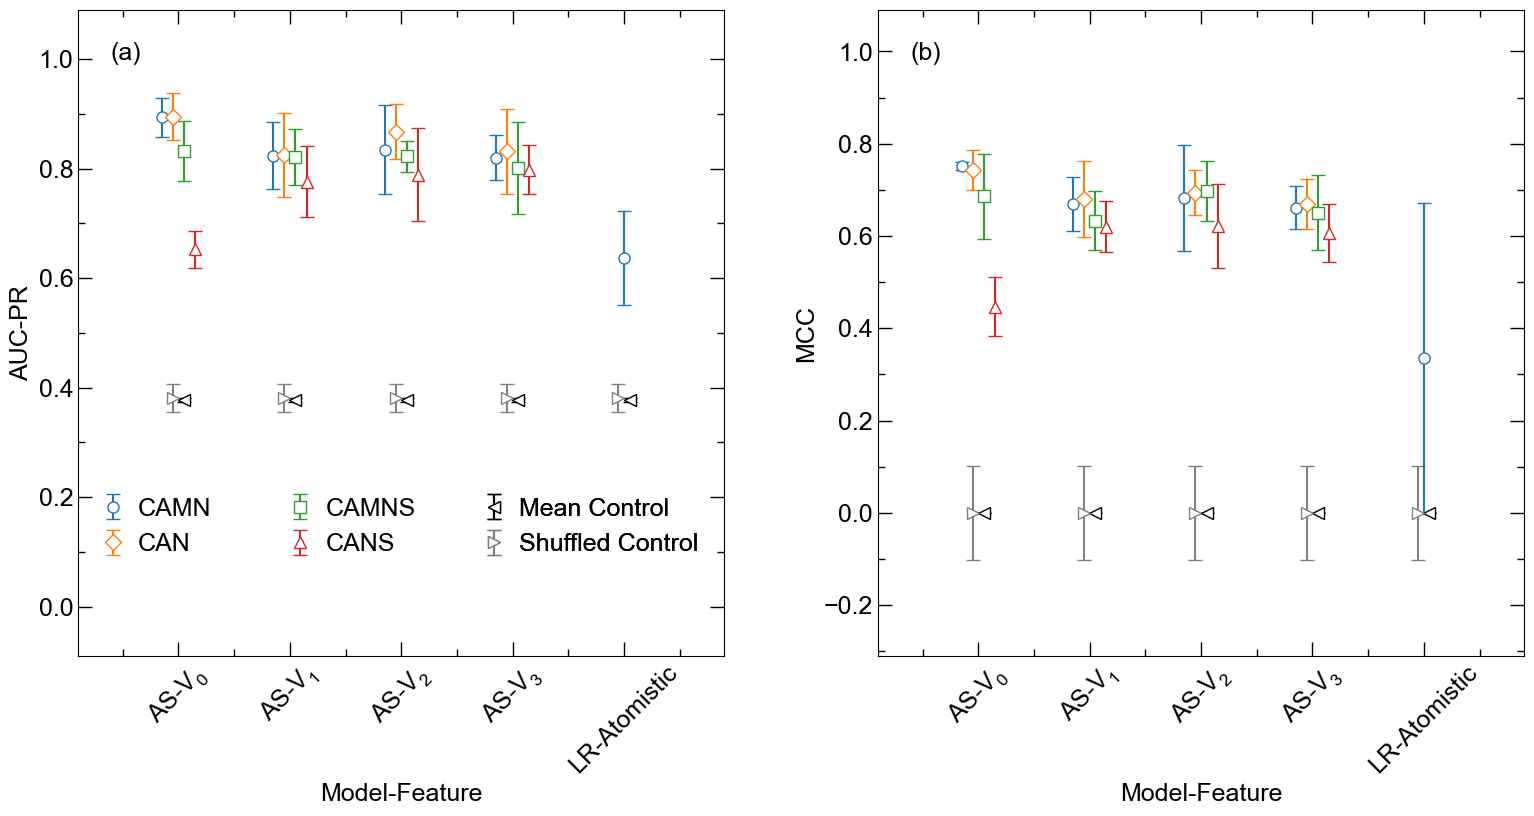

In [17]:
plt.rcParams['font.family'] = 'Arial'
params = {'mathtext.default': 'regular' }          
plt.rcParams.update(params)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
plt.subplots_adjust(wspace=None, hspace=None)

kfold_data = pd.read_csv(kfold_results_path)

colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "black", "grey", "tab:purple"]
markers = ['o', 'D', 's', '^', '<', '>', 'v']
simplifications = ['CAMN', 'CAN', 'CAMNS', 'CANS']
labels = [r'AS-V$_{0}$', r'AS-V$_{1}$', r'AS-V$_{2}$', r'AS-V$_{3}$', 'LR-Atomistic']

# Set edge colors for all borders
for ax in [ax1, ax2]:
    for spine in ax.spines.values():
        spine.set_edgecolor('black')

ax1.set_xlabel('Model-Feature', fontsize=18)
ax1.set_ylabel('AUC-PR', fontsize=18)
ax1.set_ylim([-0.09, 1.09])
ax1.set_xlim([-0.9, 4.9])
ax1.text(0.05, 0.95, '(a)', fontsize=18, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes)
ax1.set_aspect(np.diff(ax1.get_xlim()) / np.diff(ax1.get_ylim()))

x_coords = np.arange(5)
offsets = [-0.15, -0.05, 0.05, 0.15]
for i, simplification in enumerate(simplifications):
    model_avgs = []
    model_stds = []
    for feature_matrix in ['V0', 'V1', 'V2', 'V3']:
        model_feature_name = f'AS-{simplification}-{feature_matrix}'
        model_avgs.append(kfold_data[kfold_data['model_feature'] == model_feature_name]['auc_pr'].values[0])
        model_stds.append(kfold_data[kfold_data['model_feature'] == model_feature_name]['auc_pr_std'].values[0])
    ax1.errorbar(x_coords[0:4] + offsets[i], 
            model_avgs, 
            yerr=model_stds, 
            marker=markers[i],
            linestyle='',
            color=colors[i],
            markersize=8, 
            markerfacecolor='w',
            capsize=5,
            label=simplification)

shuffled_control_avg = kfold_data[kfold_data['model_feature'] == 'Shuffled Control']['auc_pr'].values[0]
shuffled_control_std = kfold_data[kfold_data['model_feature'] == 'Shuffled Control']['auc_pr_std'].values[0]

mean_control_avg = kfold_data[kfold_data['model_feature'] == 'Mean Control']['auc_pr'].values[0]
mean_control_std = kfold_data[kfold_data['model_feature'] == 'Mean Control']['auc_pr_std'].values[0]

ax1.errorbar(x=x_coords+0.05,
             y=np.full(len(x_coords), mean_control_avg),
             yerr=np.full(len(x_coords), mean_control_std), 
             fmt=markers[4], 
             color='black',
             markersize=8, 
             markerfacecolor='w',
             capsize=5,
             label='Mean Control')

ax1.errorbar(x=x_coords-0.05,
             y=np.full(len(x_coords), shuffled_control_avg),
             yerr=np.full(len(x_coords), shuffled_control_std), 
             fmt=markers[5], 
             color='gray',
             markersize=8, 
             markerfacecolor='w',
             capsize=5,
             label='Shuffled Control')

lr_atomistic_avg = kfold_data[kfold_data['model_feature'] == 'LR-Atomistic']['auc_pr'].values[0]
lr_atomistic_std = kfold_data[kfold_data['model_feature'] == 'LR-Atomistic']['auc_pr_std'].values[0]

ax1.errorbar(x_coords[-1], 
        lr_atomistic_avg, 
        yerr=lr_atomistic_std, 
        marker=markers[0],
        linestyle='',
        color=colors[0],
        markersize=8, 
        markerfacecolor='w',
        capsize=5,
        )

ax1.set_xticks(x_coords)
ax1.set_xticklabels(labels, rotation=45, ha='center')
ax1.tick_params(axis='both', which='major', direction='in', length=10, width=1, labelsize=18, colors='k', top=True, right=True)
ax1.tick_params(axis='both', which='minor', direction='in', length=5, width=1, colors='k', top=True, right=True)
ax1.minorticks_on()
ax1.xaxis.set_minor_locator(ticker.AutoMinorLocator(2))
ax1.yaxis.set_minor_locator(ticker.AutoMinorLocator(2))

handles, legend_labels = ax1.get_legend_handles_labels()

order = [0, 1, 2, 3, 4, 5]

group1_handles = [handles[idx] for idx in order[:2]]
group2_handles = [handles[idx] for idx in order[2:4]]
group3_handles = [handles[idx] for idx in order[4:]]

group1_labels = [legend_labels[idx] for idx in order[:2]]
group2_labels = [legend_labels[idx] for idx in order[2:4]]
group3_labels = [legend_labels[idx] for idx in order[4:]]

legend1 = ax1.legend(group1_handles, group1_labels, loc='center left', bbox_to_anchor=(-0.02, 0.2), fontsize=18, frameon=False, handletextpad=0.01)
legend2 = ax1.legend(group2_handles, group2_labels, loc='center left', bbox_to_anchor=(0.27, 0.2), fontsize=18, frameon=False, handletextpad=0.01)
legend3 = ax1.legend(group3_handles, group3_labels, loc='center left', bbox_to_anchor=(0.57, 0.2), fontsize=18, frameon=False, handletextpad=0.01)

ax1.add_artist(legend1)
ax1.add_artist(legend2)
ax1.add_artist(legend3)

# Second Sub plot
ax2.set_xlabel('Model-Feature', fontsize=18)
ax2.set_ylabel('MCC', fontsize=18)
ax2.set_ylim([-0.31, 1.09])
ax2.set_xlim([-0.9, 4.9])
ax2.text(0.05, 0.95, '(b)', fontsize=18, verticalalignment='top', horizontalalignment='left', transform=ax2.transAxes)
ax2.set_aspect(np.diff(ax2.get_xlim()) / np.diff(ax2.get_ylim()))

x_coords = np.arange(5)
offsets = [-0.15, -0.05, 0.05, 0.15]
for i, simplification in enumerate(simplifications):
    model_avgs = []
    model_stds = []
    for feature_matrix in ['V0', 'V1', 'V2', 'V3']:
        model_feature_name = f'AS-{simplification}-{feature_matrix}'
        model_avgs.append(kfold_data[kfold_data['model_feature'] == model_feature_name]['mcc'].values[0])
        model_stds.append(kfold_data[kfold_data['model_feature'] == model_feature_name]['mcc_std'].values[0])
    ax2.errorbar(x_coords[0:4] + offsets[i], 
            model_avgs, 
            yerr=model_stds, 
            marker=markers[i],
            linestyle='',
            color=colors[i],
            markersize=8, 
            markerfacecolor='w',
            capsize=5,
            label=simplification)

shuffled_control_avg = kfold_data[kfold_data['model_feature'] == 'Shuffled Control']['mcc'].values[0]
shuffled_control_std = kfold_data[kfold_data['model_feature'] == 'Shuffled Control']['mcc_std'].values[0]

mean_control_avg = kfold_data[kfold_data['model_feature'] == 'Mean Control']['mcc'].values[0]
mean_control_std = kfold_data[kfold_data['model_feature'] == 'Mean Control']['mcc_std'].values[0]

ax2.errorbar(x=x_coords+0.05,
             y=np.full(len(x_coords), mean_control_avg),
             yerr=np.full(len(x_coords), mean_control_std), 
             fmt=markers[4], 
             color='black',
             markersize=8, 
             markerfacecolor='w',
             capsize=5,
             label='Mean Control')

ax2.errorbar(x=x_coords-0.05,
             y=np.full(len(x_coords), shuffled_control_avg),
             yerr=np.full(len(x_coords), shuffled_control_std), 
             fmt=markers[5], 
             color='gray',
             markersize=8, 
             markerfacecolor='w',
             capsize=5,
             label='Shuffled Control')

lr_atomistic_avg = kfold_data[kfold_data['model_feature'] == 'LR-Atomistic']['mcc'].values[0]
lr_atomistic_std = kfold_data[kfold_data['model_feature'] == 'LR-Atomistic']['mcc'].values[0]

ax2.errorbar(x_coords[-1], 
        lr_atomistic_avg, 
        yerr=lr_atomistic_std, 
        marker=markers[0],
        linestyle='',
        color=colors[0],
        markersize=8, 
        markerfacecolor='w',
        capsize=5,
        label='')

ax2.set_xticks(x_coords)
ax2.set_xticklabels(labels, rotation=45, ha='center')
ax2.tick_params(axis='both', which='major', direction='in', length=10, width=1, labelsize=18, colors='k', top=True, right=True)
ax2.tick_params(axis='both', which='minor', direction='in', length=5, width=1, colors='k', top=True, right=True)
ax2.minorticks_on()
ax2.xaxis.set_minor_locator(ticker.AutoMinorLocator(2))
ax2.yaxis.set_minor_locator(ticker.AutoMinorLocator(2))

plt.tight_layout()
plt.savefig('../figures/kfold.png', dpi=450,  bbox_inches='tight')
plt.show()